### Setting

In [318]:
from gnews import GNews

import pandas as pd

from datetime import date, timedelta

import os
import re
import ast

### Crawler

In [4]:
google_news = GNews(language='en', country='US', period='1d')

start_date = date(2020, 1, 1)
end_date = date(2020, 1, 2)

news_info = []
empty_list = [] # 뉴스가 하나도 없는 날짜

excel_file = f'news_data_{start_date.year}_{start_date.month}.xlsx'
current_month = start_date.month

while start_date <= end_date:
    google_news.start_date = start_date
    google_news.end_date = start_date + timedelta(days=1)  # Set end date as the next day of start date
    
    news = google_news.get_news('tesla')
    
    print(f"크롤링 중인 날짜: {start_date}:", start_date,'해당 날짜에 뉴스 갯수',len(news))

    if len(news) == 0:  # 뉴스가 하나도 없는 날
        empty_list.append(start_date)

    for article in news:
        news_info.append([article['publisher'], article['published date'], article['title'], article['description']])

    # 달이 변경되면 
    if start_date.month != current_month:
        df = pd.DataFrame(news_info, columns=['Publisher', 'Date', 'Title', 'Description'])
        df.to_excel(excel_file, index=False)
        
        news_info = []  # 리스트를 초기화합니다.
        current_month = start_date.month
        excel_file = f'news_data_{start_date.year}_{start_date.month}.xlsx'  # 새로운 엑셀 파일 이름을 설정합니다.

    start_date += timedelta(days=1)  # Increment start date by one day

df = pd.DataFrame(news_info, columns=['Publisher', 'Date', 'Title', 'Description'])
df.to_excel(excel_file, index=False)

print("뉴스가 하나도 없는 날 : ", empty_list)

C:\Users\jjska\AppData\Local\Temp\ipykernel_50572\3426767368.py:16: UserWarning: 
Period (1d) will be ignored in favour of the start and end dates
  news = google_news.get_news('tesla')


크롤링 중인 날짜: 2020-01-01: 2020-01-01 해당 날짜에 뉴스 갯수 7


C:\Users\jjska\anaconda3\lib\site-packages\gnews\gnews.py:138: UserWarning: The start and end dates should be at least 1 day apart, or GNews will return no results
  warnings.warn("The start and end dates should be at least 1 day apart, or GNews will return no results")


크롤링 중인 날짜: 2020-01-02: 2020-01-02 해당 날짜에 뉴스 갯수 22
뉴스가 하나도 없는 날 :  []


### Data Transformation

In [384]:
# 데이터가 있는 디렉토리
data_dir = "C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/Crawler_dataset/Monthly"
output_dir = "C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/Output"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

all_data = pd.DataFrame()
title_df = pd.DataFrame()

for filename in sorted(os.listdir(data_dir)):
    file_path = os.path.join(data_dir, filename)
    
    if not filename.endswith('.xlsx'):
        continue

    df = pd.read_excel(file_path)
    print(file_path)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.strftime('%Y.%m.%d')

    # 'Publisher' 컬럼의 'title' 값만 추출
    df['Publisher'] = df['Publisher'].apply(lambda x: ast.literal_eval(x)['title'] if pd.notnull(x) else x)

    # 'Title' 컬럼에서 'Publisher' 값을 제거
    df['Title'] = df.apply(lambda row: row['Title'].replace(row['Publisher'], '').strip(), axis=1)

    # 'Description' 컬럼에서 'Publisher' 값을 제거
    df['Description'] = df.apply(lambda row: row['Description'].replace(row['Publisher'], '').strip() if pd.notnull(row['Description']) else row['Description'], axis=1)

    # 'Description' 컬럼의 값에서 영어가 아닌 문자 제거
    df['Description'] = df['Description'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

    # 'Description' 컬럼의 값에서 영어가 아닌 한자, 한국어, 일본어 등 제거
    df['Description'] = df['Description'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))
    
    title_df = title_df._append(df, ignore_index=True)
    
    # 'Date' 컬럼으로 그룹화하고 'Publisher'와 'Description' 컬럼을 각각 합침
    df_consolidated = df.groupby(['Date']).agg({'Publisher': ' '.join, 'Description': ' '.join}).reset_index()

    # 그룹의 크기를 나타내는 'News_Count'라는 열을 추가
    df_consolidated['News_Count'] = df.groupby(['Date']).size().values

    # 모든 데이터를 저장하는 데이터프레임에 추가
    all_data = all_data._append(df_consolidated, ignore_index=True)

# 'Date' 컬럼을 datetime 형식으로 변환
all_data['Date'] = pd.to_datetime(all_data['Date'])

# 날짜에서 요일을 추출 (월요일: 0, 일요일: 6)
all_data['weekday'] = all_data['Date'].dt.weekday

# 요일이 토요일(5), 일요일(6)인 경우 그 다음 월요일로 변경한 날짜를 'group_date'라는 새로운 컬럼에 저장
all_data['group_date'] = all_data.apply(lambda row: row['Date'] + pd.DateOffset(days=(7 - row['weekday'])) if row['weekday'] in [5, 6] else row['Date'], axis=1)

# 'group_date' 컬럼의 이름을 'Date'로 변경
all_data.rename(columns={'group_date': 'new_date'}, inplace=True)
all_data.head()

C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/Crawler_dataset/Monthly\news_data_2020_1.xlsx
C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/Crawler_dataset/Monthly\news_data_2020_10.xlsx
C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/Crawler_dataset/Monthly\news_data_2020_11.xlsx
C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/Crawler_dataset/Monthly\news_data_2020_12.xlsx
C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/Crawler_dataset/Monthly\news_data_2020_2.xlsx
C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/Crawler_dataset/Monthly\news_data_2020_3.xlsx
C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/Crawler_dataset/Monthly\news_data_2020_4.xlsx
C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/Crawler_dataset/Monthly\news_data_2020_5.xlsx
C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/Crawler_dataset/Monthly\news_data_2020_6.xlsx
C:/Users/jjska/Desktop/StockPredictionByTextMining/D

,Date,Publisher,Description,News_Count,weekday,new_date
0,2020-01-01,CarBuzz CarBuzz Globes Electrek,Tesla Cybertruck Makes Music Video Debut AllNe...,4,2,2020-01-01
1,2020-01-02,The Guardian Gulf News TechCrunch Reuters Inve...,Tesla may have been on Autopilot in California...,21,3,2020-01-02
2,2020-01-03,Khmer Times Khmer Times Fossbytes CNBC The Ver...,Tesla to provide movies online games in its ca...,27,4,2020-01-03
3,2020-01-04,Terre Haute Tribune Star Mashable CarScoops In...,I70 crash one of 3 raising questions about Tes...,6,5,2020-01-06
4,2020-01-05,GTspirit Bloomberg CleanTechnica WIRED CleanTe...,Minimalist Tesla Cybertruck Inspires Russian C...,18,6,2020-01-06


In [367]:
title2_df = title_df.copy()
title2_df

,Publisher,Date,Title,Description
0,The Guardian,2020.01.02,Tesla may have been on Autopilot in California...,Tesla may have been on Autopilot in California...
1,CarBuzz,2020.01.01,Tesla Cybertruck Makes Music Video Debut -,Tesla Cybertruck Makes Music Video Debut
2,CarBuzz,2020.01.01,All-New Tesla Model S Could Look Like This -,AllNew Tesla Model S Could Look Like This
3,Globes,2020.01.01,Tesla setting up Israel R&D office - -,Tesla setting up Israel RD office
4,Electrek,2020.01.01,Tesla updates 2020 Supercharger map with new l...,Tesla updates 2020 Supercharger map with new l...
...,...,...,...,...
17781,Torque News,2022.10.01,What A Tesla Model 3 Could Mean For You -,What A Tesla Model 3 Could Mean For You
17782,Hindustan Times,2022.10.02,Want to work for Tesla? Elon Musk tweets askin...,Want to work for Tesla Elon Musk tweets asking...
17783,CNN en Español,2022.10.01,El robot de Tesla caminó lentamente sobre el e...,El robot de Tesla camin lentamente sobre el es...
17784,TheStreet,2022.10.01,New Electric Vehicle Beats Tesla When it Comes...,New Electric Vehicle Beats Tesla When it Comes...


In [385]:
# 'Date' 컬럼으로 그룹화하여 'Publisher', 'Description', 'News_Count' 컬럼의 값들을 합침
all_data_grouped = all_data.groupby(['new_date']).agg({'Publisher': ' '.join, 'Description': ' '.join, 'News_Count': 'sum'}).reset_index()
all_data_grouped = all_data_grouped.sort_values(by=["new_date"], ascending=[True]) 
all_data_grouped = all_data_grouped[all_data_grouped['new_date'] <= '2022-12-31']

def str_to_list(char):
    return list(set(list(char.split(" "))))
    
all_data_grouped['Publisher'] = all_data_grouped['Publisher'].apply(str_to_list)
all_data_grouped

,new_date,Publisher,Description,News_Count
0,2020-01-01,"[Globes, Electrek, CarBuzz]",Tesla Cybertruck Makes Music Video Debut AllNe...,4
1,2020-01-02,"[Torque, 01net, EL, GSMArena.com, Gulf, Exteri...",Tesla may have been on Autopilot in California...,21
2,2020-01-03,"[CleanTechnica, ONLINE, CarBuzz, Khmer, Yahoo,...",Tesla to provide movies online games in its ca...,27
3,2020-01-06,"[CleanTechnica, Torque, CarBuzz, EL, Samochody...",I70 crash one of 3 raising questions about Tes...,45
4,2020-01-07,"[Motori, CleanTechnica, CarBuzz, Indonesia, ZE...",China could be the swing factor for Teslas sto...,27
...,...,...,...,...
778,2022-12-26,"[Financial, Torque, CleanTechnica, CarBuzz, Ex...",Elon Musks Twitter obsession isnt the core rea...,24
779,2022-12-27,"[Telex, Reuters, Torque, Forbes, CarScoops, CN...",Why Tesla Stocks Dropped So Much in 2022 Tesla...,14
780,2022-12-28,"[CleanTechnica, Torque, TODAY, Yahoo, Times, I...",Bus und Bahn in Oberhavel Weniger Zulassungen ...,18
781,2022-12-29,"[Financial, Torque, CarBuzz, PAHomePage.com, Y...",Musk tells Tesla workers not to be bothered by...,20


### Data Preprocessing

#### Setting

In [321]:
tsla_df = all_data_grouped.copy()
tsla_df.rename(columns={'new_date':'Date'}, inplace = True)
tsla_df.head()

,Date,Publisher,Description,News_Count
0,2020-01-01,"[Globes, Electrek, CarBuzz]",Tesla Cybertruck Makes Music Video Debut AllNe...,4
1,2020-01-02,"[Torque, 01net, EL, GSMArena.com, Gulf, Exteri...",Tesla may have been on Autopilot in California...,21
2,2020-01-03,"[CleanTechnica, ONLINE, CarBuzz, Khmer, Yahoo,...",Tesla to provide movies online games in its ca...,27
3,2020-01-06,"[CleanTechnica, Torque, CarBuzz, EL, Samochody...",I70 crash one of 3 raising questions about Tes...,45
4,2020-01-07,"[Motori, CleanTechnica, CarBuzz, Indonesia, ZE...",China could be the swing factor for Teslas sto...,27


In [322]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

import spacy

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer


lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

nlp = spacy.load('en_core_web_sm')

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stopwords_default = stopwords.words('english')
custom_stop_words = set(ENGLISH_STOP_WORDS)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jjska\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jjska\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jjska\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [323]:
# 추가적인 불용어 카테고리별로 설정
general_stopwords = ['with', 'was', 'will', 'why', 'what', 'you', 'your', 'who', 'yet', 'years', 'world', 'working', 'work', 'we', 'when']
brand_stopwords = ['tesla', 'volvo', 'volkswagen', 'xpeng']
tech_stopwords = ['video', 'updates', 'youtuber', 'youtube', 'windows', 'wifi', 'wireless', 'watching', 'watch', 'windowbreaking', 'window', 'wing']
car_stopwords = ['vehicles', 'truckers', 'transportation', 'trucks', 'vehicle']
date_stopwords = ['january', 'fabruary', 'march','april','may','june','july','agust','september','october','november','december']
other_stopwords = ['do']

all_additional_stopwords = general_stopwords +date_stopwords + other_stopwords

for stopword in all_additional_stopwords:
    stopwords_default.append(stopword)


# 전처리 : 표제어 + 불용어 적용 안되는 것
noun_words = ['beans', 'murphy','rockets',
              'producevehicle','games','airlines','operators','facilities',
              'videos','claims','masks','nations','vehicles','ploblems','photos',
              'sits','relations','covers','hands','tensions','capabilities','nations','requests','endorsements',
              'teams', 'ploblems','areas','streets','signs','possiblities','workers','sales','adopters','developments',
              'companies','clubs','dashboards','powerwalls','panalties','challenges','tasks','machines','households',
              'negotiations','politics','overseas','homeowners','wars','movies','autospies','paneles','withdraws',
              'margins','automakers','nuevos','flaws','deepfakes','believers','angeles','spacers','deliveries','fails']
verb_words = ['have','waived','involving','abundoning','contribute','engaged','recalled','intensifying','led','curves',
              'received', 'charges', 'investigating', 'intensifying', 'said','retreating','considering','remains','began','displayed',
              'fired','lined','depanding','blamed','killing','sitting','opted','enticing','reviewing','contends','missed','balancing',
              'anticipated','jumped','delievered','shifted','killed','concerning','arrived','defects','argued','disclosed',
              'explained','appears','stopped','depending','battered','thinking','pressured','slowing','tumbling','tensifying',
              'explained','restarts','admitted','demands','totaled','demonstrates','opposing','interested','acting','taken','braking',
              'peaking','dethroned','met','guessed','developer','outstanding','performing','loaded','rides','launched','allows',
              'thrilled','operated','refusing','slumped','affected','appeared','removing','saying','related','troubled',
              'advanced','raised','killed','defects','crewed','performing','leaving','got','explains','raising',
              'inspires','injured','sales','powered','pulled','cutting','fleeing','creating','growing','coming',
              'leasing','promising','revealed','nailed','did','linking','tuned','optimizes','badged',
              'receives','patched','encourageing','thought','recommends','combined','endangered','counterfeiting',
              'challenging','owned','missing','creates','closing','won','hinting','billing','rolling','nears','breaking','given',
              'commemorating','receiving','going','targeted','kicking','replaced','seeking','promotes','taking',
              'stealing','spotted','celebrating','extended','preserving','allows','cutting','including','positioning',
              'extends','enabled','fixing','replacing','promotes','sends','flying','replanting','responds','rumoured',
              'installed','inspired','isolating','designed','earnings','jolted','adding','picking','running','rolls',
              'acquires','electrifying','sustaining','redesigned','committed','branded','launched','prepares','worked',
              'zoomed','shares','earnings','confirmed','making', 'makes','abandoning','abandoned','abandons','delievering',
              'replaces','sent','says']
adject_words = ['nearest','safer','older','worse','slower','lower','hottest','coolest','effectively','originally','cheaper']

In [324]:
# preprocessing function : 소문자화, 영어만 적용, Stemming, Lemmatization, token 화 사용함

def preprocess_sentence(sentence):
    # 소문자화와 영어 단어 추출
    sentence = sentence.lower()
    words = re.findall(r'\b[a-z]+\b', sentence)

    # Spacy를 사용하여 텍스트를 처리합니다.
    doc = nlp(' '.join([word for word in words if word not in stopwords_default]))

    # 불용어를 제거하고, 각 토큰을 원형으로 변환합니다.
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    
      ## 표제어 추출
    # noun_words의 단어를 명사로 표제어 추출
    tokens = [lemmatizer.lemmatize(word, pos='n') if word in noun_words else word for word in tokens]
    # verb_words의 단어를 동사로 표제어 추출
    tokens = [lemmatizer.lemmatize(word, pos='v') if word in verb_words else word for word in tokens]
    # adject_words의  단어를 형용사로 표제어 추출
    tokens = [lemmatizer.lemmatize(word, pos='a') if word in adject_words else word for word in tokens]
    tokens = list(set(tokens))
    tokens = [token for token in tokens if len(token)>2]

    return ' '.join(tokens)

In [325]:
tsla_df['corpus'] = tsla_df['Description'].apply(preprocess_sentence)

In [326]:
def list_to_set(x):
    x = list(x)
    return list(set(x))

tsla_df['Publisher'] = tsla_df['Publisher'].apply(list_to_set)
tsla_df.head()

,Date,Publisher,Description,News_Count,corpus
0,2020-01-01,"[Globes, Electrek, CarBuzz]",Tesla Cybertruck Makes Music Video Debut AllNe...,4,update make allnew office video set cybertruck...
1,2020-01-02,"[Torque, 01net, EL, GSMArena.com, Gulf, Exteri...",Tesla may have been on Autopilot in California...,21,price influential china voor end deja vdeo sup...
2,2020-01-03,"[CleanTechnica, ONLINE, CarBuzz, Khmer, Yahoo,...",Tesla to provide movies online games in its ca...,27,price china well med reduction provide youtube...
3,2020-01-06,"[Torque, CleanTechnica, CarBuzz, Samochody, EL...",I70 crash one of 3 raising questions about Tes...,45,price ratio drodze question trigger kolejna es...
4,2020-01-07,"[CleanTechnica, Motori, Indonesia, CarBuzz, ZE...",China could be the swing factor for Teslas sto...,27,china shanghai ford nontesla lauto een mobil p...


In [327]:
tsla_df.to_csv(os.path.join(output_dir, "preprocessed_data.csv"), index=False)

### Text Vectorization(Using TF-IDF)

#### Setting

In [328]:
import numpy as np

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FuncFormatter
%matplotlib inline

from PIL import Image

from sklearn.decomposition import PCA, LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer, normalize

In [329]:
# 뉴스 데이터 가져오기
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(tsla_df['corpus'])
feature_names = tfidf_vectorizer.get_feature_names_out()

# 단어 목록을 행으로 하는 tfidf 행렬
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df.shape

(783, 17454)

#### word -featuring : 분석에 사용할 키워드 갯수 정하기, 뉴스에서 사용할 최소한의 키워드

#### 설명 : 지금 부터 사용할 5가지의 메트릭은 뉴스에서 사용할 최소한의 키워드 갯수를 정하는 5가지 Metric 이다.

In [26]:
# visualization function
def plot_keywords(x, y, y_label, title):

    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(10,6))

    plt.plot(x, y,  marker='o', color = 'b')

    plt.gca().invert_xaxis()

    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)

    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().set_facecolor('lightgray')
    plt.grid(color='white', linestyle='-', linewidth=1)

    k_formatter = FuncFormatter(lambda x, pos: f'K{x}')
    plt.gca().xaxis.set_major_formatter(k_formatter)

    plt.xticks(range(min(keyword_counts), max(keyword_counts)+1))

    plt.xlabel('Number of selected top keywords from each data')
    plt.ylabel(y_label)

    # for i in [3, 4, 5]:
    #     if i in x:
    #         index = x.index(i)
    #         plt.plot(i, y[index], marker='o', color='y')

    plt.title(title)
    plt.show()

keyword_counts = list(range(20, 1, -1))
tfidf_matrix_transposed = tfidf_matrix.toarray()

#### Metric 1 : Mean of the TF-IDF scores of a word-feature across data

C:\Users\jjska\AppData\Local\Temp\ipykernel_50572\578327706.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


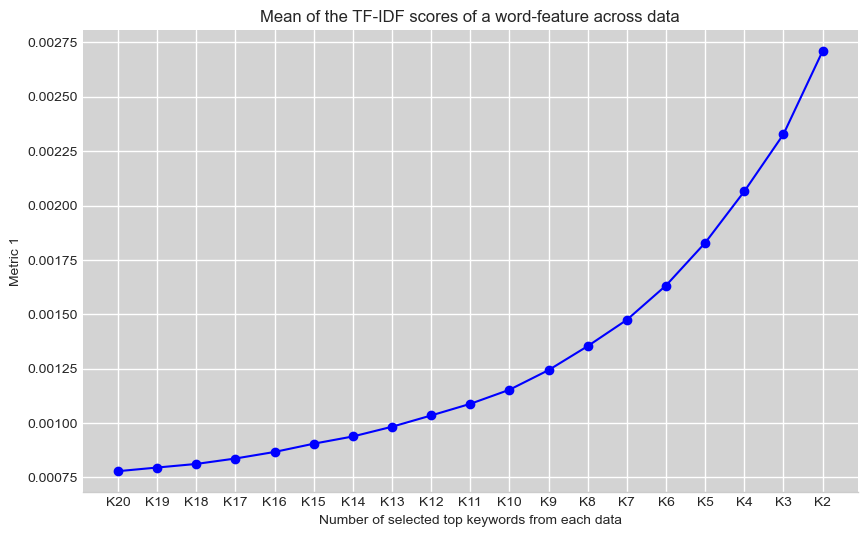

In [27]:
mean_tfidf_scores = []

for count in keyword_counts:
    top_keywords = []

    for doc_idx in range(len(df)):
        tfidf_scores = tfidf_matrix[doc_idx].toarray()[0]
        top_indices = np.argsort(tfidf_scores)[-count:]
        top_keywords.extend([feature_names[idx] for idx in top_indices])
    top_keywords = list(set(top_keywords))

    keyword_indices = [np.where(np.array(feature_names) == keyword)[0][0] for keyword in top_keywords]
    keyword_tfidf_scores = tfidf_matrix[:, keyword_indices].toarray()

    # TF-IDF score 평균 계산
    mean_tfidf_score = np.mean(keyword_tfidf_scores)
    mean_tfidf_scores.append(mean_tfidf_score)

plot_keywords(keyword_counts, mean_tfidf_scores, 'Metric 1',  'Mean of the TF-IDF scores of a word-feature across data')

#### Metric 2 : Mean of the cosine similarities of a word-feature to other features


C:\Users\jjska\AppData\Local\Temp\ipykernel_50572\578327706.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


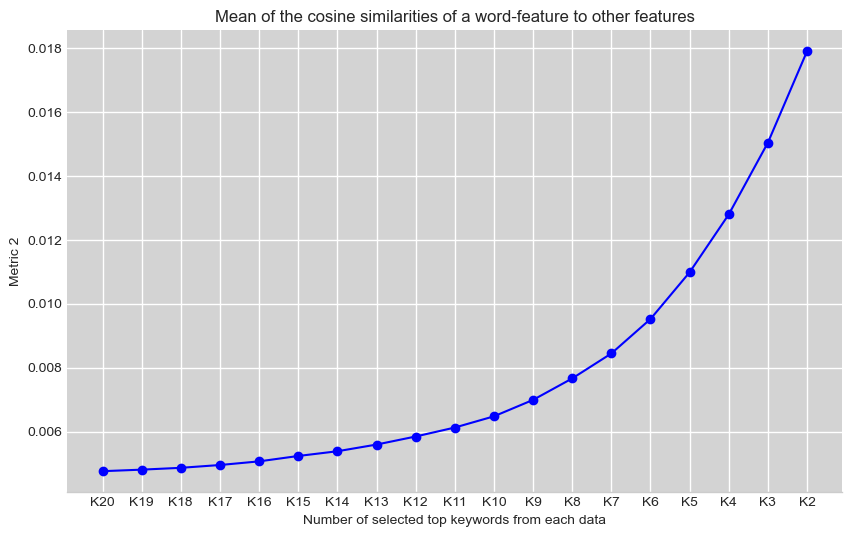

In [28]:
mean_cosine_similarities = []

for num_keywords in keyword_counts:
    top_keywords = []

    for doc_idx in range(len(df)):
        tfidf_scores = tfidf_matrix[doc_idx].toarray()[0]
        top_indices = np.argsort(tfidf_scores)[-num_keywords:]
        top_keywords.extend([feature_names[idx] for idx in top_indices])

    top_keywords = list(set(top_keywords))

    keyword_indices = [np.where(np.array(feature_names) == keyword)[0][0] for keyword in top_keywords]
    keyword_matrix = tfidf_matrix[:, keyword_indices].T
    cosine_similarities = cosine_similarity(keyword_matrix)

    mean_cosine_similarity = np.mean(cosine_similarities)
    mean_cosine_similarities.append(mean_cosine_similarity)

plot_keywords(keyword_counts, mean_cosine_similarities,'Metric 2', 'Mean of the cosine similarities of a word-feature to other features')

#### Metric 3 : Cosine similarity between a word-feature and the centroid of features

C:\Users\jjska\AppData\Local\Temp\ipykernel_50572\578327706.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


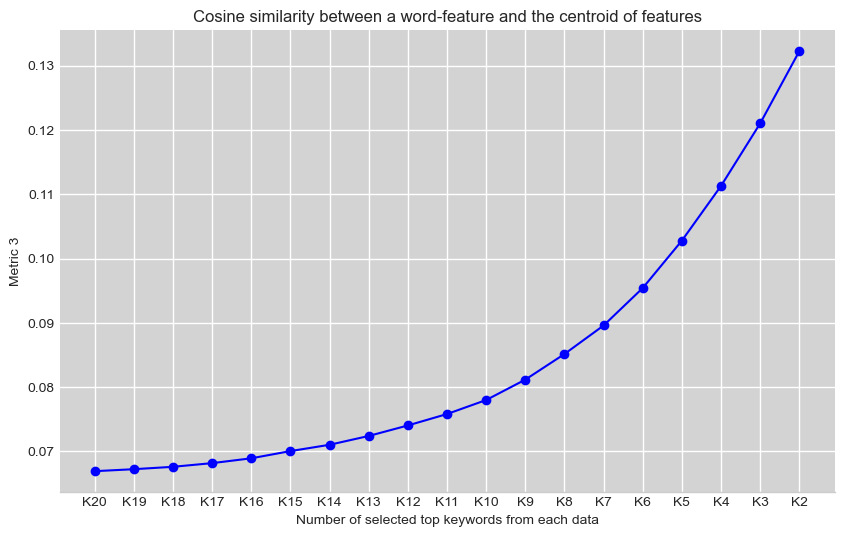

In [29]:
median_cosine_similarities = []

for count in keyword_counts:
    top_keywords = []

    for doc_idx in range(len(df)):
        tfidf_scores = tfidf_matrix[doc_idx].toarray()[0]
        top_indices = np.argsort(tfidf_scores)[-count:]
        top_keywords.extend([feature_names[idx] for idx in top_indices])

    top_keywords = list(set(top_keywords))

    keyword_indices = [np.where(np.array(feature_names) == keyword)[0][0] for keyword in top_keywords]
    keyword_matrix = tfidf_matrix[:, keyword_indices]

    keyword_matrix = keyword_matrix.T.toarray()

    centroid = np.mean(keyword_matrix, axis=0)
    centroid = np.asarray(centroid).reshape(1, -1)

    cosine_similarities = []

    for idx in range(keyword_matrix.shape[0]):
        word_vector = keyword_matrix[idx, :]
        word_vector = np.asarray(word_vector).reshape(1, -1)
        cosine_similarity_value = cosine_similarity(word_vector, centroid)
        cosine_similarities.append(cosine_similarity_value[0][0])


    mean_cosine_similarity = np.mean(cosine_similarities)
    median_cosine_similarities.append(mean_cosine_similarity)

plot_keywords(keyword_counts, median_cosine_similarities, "Metric 3", "Cosine similarity between a word-feature and the centroid of features")

#### Metric 4 : Mean of the dot product scores of a word-feature to other features

C:\Users\jjska\AppData\Local\Temp\ipykernel_50572\578327706.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


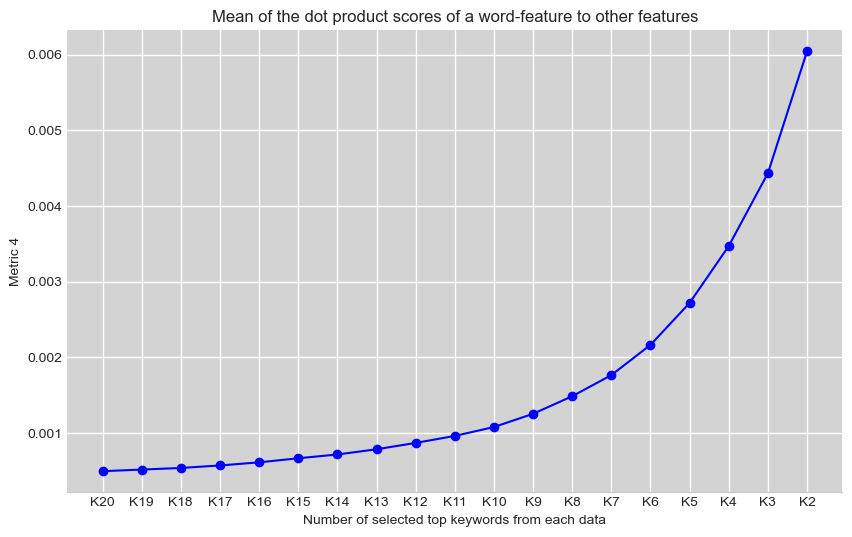

In [30]:
mean_dot_product_scores = []

for count in keyword_counts:
    top_keywords = []

    for doc_idx in range(len(df)):
        tfidf_scores = tfidf_matrix[doc_idx].toarray()[0]
        top_indices = np.argsort(tfidf_scores)[-count:]
        top_keywords.extend([feature_names[idx] for idx in top_indices])

    top_keywords = list(set(top_keywords))

    keyword_indices = [np.where(np.array(feature_names) == keyword)[0][0] for keyword in top_keywords]
    keyword_tfidf_scores = tfidf_matrix[:, keyword_indices].toarray()
    dot_product_scores = np.dot(keyword_tfidf_scores.T, keyword_tfidf_scores)

    mean_dot_product_score = np.mean(dot_product_scores)
    mean_dot_product_scores.append(mean_dot_product_score)

plot_keywords(keyword_counts, mean_dot_product_scores,"Metric 4", "Mean of the dot product scores of a word-feature to other features")

#### Metric 5 : LDA score of a word-feature for the single topic of entire data set

C:\Users\jjska\AppData\Local\Temp\ipykernel_50572\578327706.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


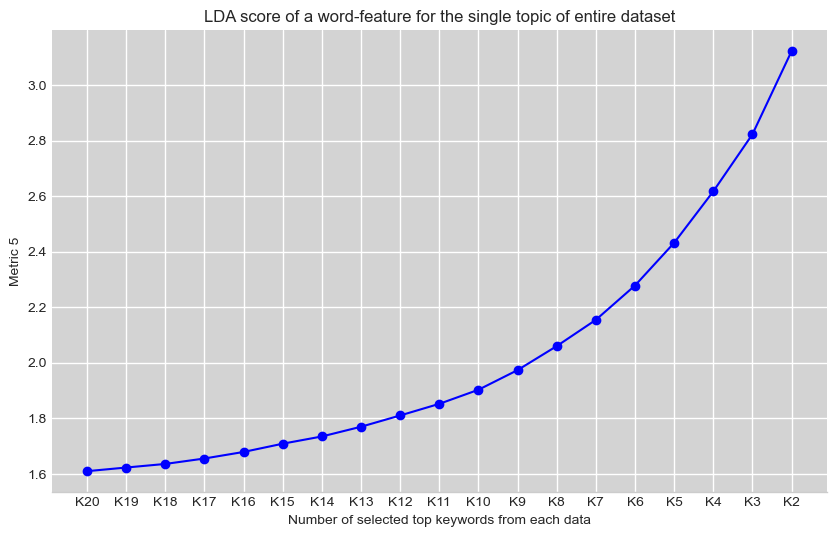

In [31]:
mean_lda_scores = []

for count in keyword_counts:
    top_keywords = []

    for doc_idx in range(len(df)):
        tfidf_scores = tfidf_matrix[doc_idx].toarray()[0]
        top_indices = np.argsort(tfidf_scores)[-count:]
        top_keywords.extend([feature_names[idx] for idx in top_indices])

    top_keywords = list(set(top_keywords))
    keyword_indices = [np.where(np.array(feature_names) == keyword)[0][0] for keyword in top_keywords]
    keyword_matrix = tfidf_matrix[:, keyword_indices].toarray()

    num_topics = 1
    lda_model = LatentDirichletAllocation(n_components=num_topics)
    lda_model.fit(keyword_matrix)

    lda_scores = lda_model.components_

    mean_lda_score = np.mean(lda_scores)
    mean_lda_scores.append(mean_lda_score)

plot_keywords(keyword_counts, mean_lda_scores,"Metric 5", "LDA score of a word-feature for the single topic of entire dataset")

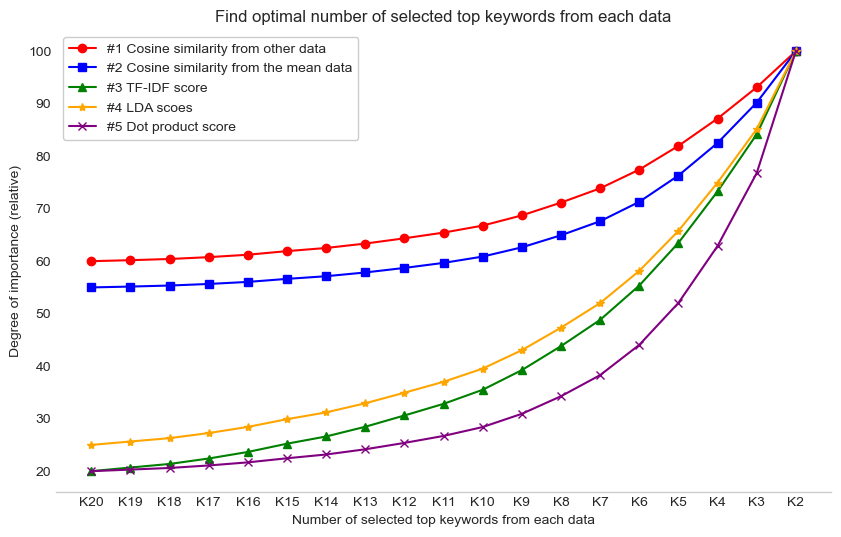

In [35]:
metric1_values = median_cosine_similarities
metric2_values = mean_cosine_similarities
metric3_values = mean_tfidf_scores
metric4_values = mean_lda_scores
metric5_values = mean_dot_product_scores

metric1_normalized = (metric1_values - np.min(metric1_values)) / (np.max(metric1_values) - np.min(metric1_values)) * 40 + 60
metric2_normalized = (metric2_values - np.min(metric2_values)) / (np.max(metric2_values) - np.min(metric2_values)) * 45 + 55
metric3_normalized = (metric3_values - np.min(metric3_values)) / (np.max(metric3_values) - np.min(metric3_values)) * 80 + 20
metric4_normalized = (metric4_values - np.min(metric4_values)) / (np.max(metric4_values) - np.min(metric4_values)) * 75 + 25
metric5_normalized = (metric5_values - np.min(metric5_values)) / (np.max(metric5_values) - np.min(metric5_values)) * 80 + 20

# plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10,6))

plt.gca().invert_xaxis()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.gca().set_facecolor('lightgray')

plt.xticks(range(min(keyword_counts), max(keyword_counts)+1))

k_formatter = FuncFormatter(lambda x, pos: f'K{x}')

plt.gca().xaxis.set_major_formatter(k_formatter)
plt.grid(color='white', linestyle='-', linewidth=1)
plt.xlabel('Number of selected top keywords from each data')
plt.ylabel('Degree of importance (relative)')

plt.plot(keyword_counts, metric1_normalized, marker='o', label='#1 Cosine similarity from other data', color='red')
plt.plot(keyword_counts, metric2_normalized, marker='s', label='#2 Cosine similarity from the mean data', color='blue')
plt.plot(keyword_counts, metric3_normalized, marker='^', label='#3 TF-IDF score', color='green')
plt.plot(keyword_counts, metric4_normalized, marker='*', label='#4 LDA scoes', color='orange')
plt.plot(keyword_counts, metric5_normalized, marker='x', label='#5 Dot product score', color='purple')

plt.xlabel('Number of selected top keywords from each data')
plt.ylabel('Degree of importance (relative)')
plt.title('Find optimal number of selected top keywords from each data')
plt.legend(frameon = True, framealpha=1)

plt.show()

In [330]:
all_keywords = []
top_keywords_per_document = []
feature_names = tfidf_vectorizer.get_feature_names_out()

for i in range(len(df)):
    tfidf_scores = zip(feature_names, tfidf_matrix[i].toarray()[0])
    sorted_tfidf_scores = sorted(tfidf_scores,key=lambda x: x[1], reverse=True)

    top_keywords_per_document.append([keyword for keyword,_ in sorted_tfidf_scores[:7]])

all_keywords=[keyword for document in top_keywords_per_document for keyword in document]

vectorizer = TfidfVectorizer(vocabulary=list(set(all_keywords)))
tfidf_matrix = vectorizer.fit_transform(tsla_df['corpus'])

print("현재 News 갯수:",tfidf_matrix.shape[0])
print("현재 word-feature 갯수:",tfidf_matrix.shape[1])

현재 News 갯수: 783
현재 word-feature 갯수: 3320


#### 설명 : 위의 과정까지가 원본 텍스트 데이터에서 전처리 및 핵심 키워드 추출 등을 거쳐서 벡터화까지 진행한 형태

#### 아래 부터 진행할 내용은 가공된 데이터를 바탕으로 필요한 정보 등을 추출하는 Description analysis

In [51]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=list(set(all_keywords)))
average_tfidf = tfidf_df.mean()
average_tfidf_dict = average_tfidf.to_dict()

In [ ]:
stopwords = ['', '', '', '', '', '']

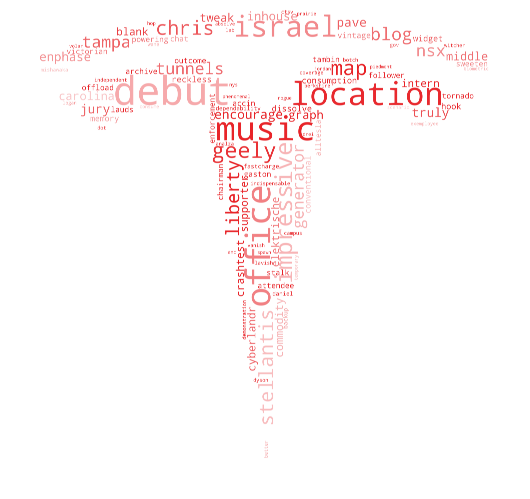

In [52]:
# 워드 클라우드 생성 함수 : Tesla News 들의 Word clound, Tesla logo 모양을 바탕으로 진행, 상위 100개만 표시함

mask = np.array(Image.open("C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/tesla_logo.jpg"))

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=list(set(all_keywords)))
average_tfidf = tfidf_df.mean()
average_tfidf_dict = average_tfidf.to_dict()

# 워드 클라우드 생성
image_colors = ImageColorGenerator(mask)

wordcloud = WordCloud(background_color="white",
                      mode="RGBA",
                      mask = mask,
                      width=800, 
                      height=800,
                      scale=2,
                      max_words=100).generate_from_frequencies(average_tfidf_dict)

image_colors = ImageColorGenerator(mask)

plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig("wordcloud.png", dpi=300)
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="antialiased")

#### 전체 데이터셋의 단순 빈도수 기반 Word Cloud

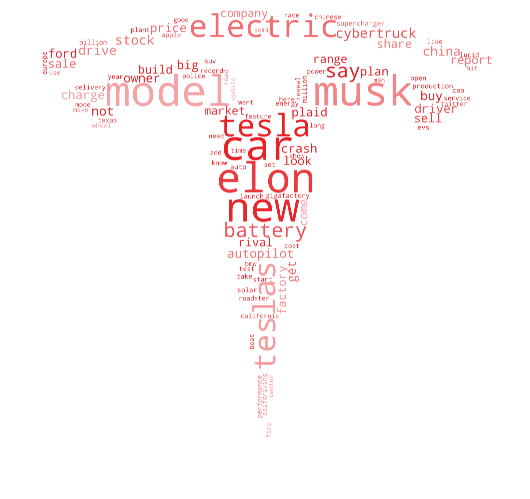

In [57]:
# 워드 클라우드 생성 함수 : Tesla News 들의 Word clound, Tesla logo 모양을 바탕으로 진행, 상위 100개만 표시함

mask = np.array(Image.open("C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/tesla_logo.jpg"))

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(tsla_df['corpus'])

word_freq = np.sum(tfidf_matrix.toarray(), axis=0)
word_freq_dict = dict(zip(vectorizer.get_feature_names_out(), word_freq))

image_colors = ImageColorGenerator(mask)

# 워드 클라우드 생성
wordcloud = WordCloud(background_color="white",
                      mode="RGBA",
                      mask = mask,
                      width=800, 
                      height=800,
                      scale=2,
                      max_words=100).generate_from_frequencies(word_freq_dict)

image_colors = ImageColorGenerator(mask)

plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig("wordcloud.png", dpi=300)
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="antialiased")

In [331]:
# DTM을 데이터프레임으로 변환
temp_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# 각 행별로 TF-IDF 값이 높은 상위 7개의 단어를 선택
top_7_words = temp_df.apply(lambda row: row.nlargest(7).index.tolist(), axis=1)

# 결과를 데이터프레임으로 변환
result_df = pd.DataFrame(top_7_words, columns=['Top_7_Words'])

# 날짜, 키워드 데이터 생성
temp_df = pd.DataFrame({
    'Date': tsla_df['Date'],
    'Keywords' : result_df['Top_7_Words']
})

temp_df.head()

,Date,Keywords
0,2020-01-01,"[allnew, map, israel, office, location, music,..."
1,2020-01-02,"[duizenden, goldsboro, coalicin, complacent, a..."
2,2020-01-03,"[drd, bootleg, aralarda, dulle, auburn, inde, ..."
3,2020-01-06,"[brandstofmotor, allweather, cristales, bomben..."
4,2020-01-07,"[gigafactora, ciclista, bloccher, benzinemotor..."


#### 일단 키워드 7개를 잘랐는데, 그 이유는 5개는 감성 사전의 효과가 없기도 하고, 7개인 지점이 elbow point 처럼 식별되기 때문

### 1. 감성 분석 - 모델명 : ?, 키워드 기반 + 전체 description으로 나눠서 진행

In [332]:
### 감성분석 ###
from collections import defaultdict

# 감성분석 점수 및 키워드를 저장할 딕셔너리 초기화
description_sentiment_scores = defaultdict(float)
keywords_sentiment_scores = defaultdict(float)
keywords_dict = defaultdict(list)

# 감성 단어 개수를 저장할 딕셔너리 초기화
description_uncertainty_count = defaultdict(int)
description_litigious_count = defaultdict(int)
description_constraining_count = defaultdict(int)
description_superfluous_count = defaultdict(int)
description_weakmodal_count = defaultdict(int)
description_positive_count = defaultdict(int)
description_negative_count = defaultdict(int)

keywords_uncertainty_count = defaultdict(int)
keywords_litigious_count = defaultdict(int)
keywords_constraining_count = defaultdict(int)
keywords_superfluous_count = defaultdict(int)
keywords_weakmodal_count = defaultdict(int)
keywords_positive_count = defaultdict(int)
keywords_negative_count = defaultdict(int)

# Loughran-McDonald 사전 로드
sentiment_df = pd.read_csv('C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/LM-SA-2020.csv')

# 감성별 사전 초기화
uncertainty_dict = defaultdict(int)
litigious_dict = defaultdict(int)
constraining_dict = defaultdict(int)
superfluous_dict = defaultdict(int)
weakmodal_dict = defaultdict(int)
positive_dict = defaultdict(int)
negative_dict = defaultdict(int)

for _, row in sentiment_df.iterrows():
    word, sentiment = row['word'], row['sentiment']
    if sentiment == 'Uncertainty':
        uncertainty_dict[word] = 1
    elif sentiment == 'Litigious':
        litigious_dict[word] = 1
    elif sentiment == 'Constraining':
        constraining_dict[word] = 1
    elif sentiment == 'Superfluous':
        superfluous_dict[word] = 1
    elif sentiment == 'WeakModal':
        weakmodal_dict[word] = 1
    elif sentiment == 'Positive':
        positive_dict[word] = 1
    elif sentiment == 'Negative':
        negative_dict[word] = -1

In [386]:
all_data = tsla_df.copy()
all_data['Keywords'] = temp_df['Keywords']
all_data.head()

,Date,Publisher,Description,News_Count,corpus,Keywords
0,2020-01-01,"[Globes, Electrek, CarBuzz]",Tesla Cybertruck Makes Music Video Debut AllNe...,4,update make allnew office video set cybertruck...,"[allnew, map, israel, office, location, music,..."
1,2020-01-02,"[Torque, 01net, EL, GSMArena.com, Gulf, Exteri...",Tesla may have been on Autopilot in California...,21,price influential china voor end deja vdeo sup...,"[duizenden, goldsboro, coalicin, complacent, a..."
2,2020-01-03,"[CleanTechnica, ONLINE, CarBuzz, Khmer, Yahoo,...",Tesla to provide movies online games in its ca...,27,price china well med reduction provide youtube...,"[drd, bootleg, aralarda, dulle, auburn, inde, ..."
3,2020-01-06,"[Torque, CleanTechnica, CarBuzz, Samochody, EL...",I70 crash one of 3 raising questions about Tes...,45,price ratio drodze question trigger kolejna es...,"[brandstofmotor, allweather, cristales, bomben..."
4,2020-01-07,"[CleanTechnica, Motori, Indonesia, CarBuzz, ZE...",China could be the swing factor for Teslas sto...,27,china shanghai ford nontesla lauto een mobil p...,"[gigafactora, ciclista, bloccher, benzinemotor..."


In [387]:
# 감성 분석 함수
def sentiment_analysis(sentence, parms):
    counts = len(sentence.split())
    
    num, sentiment_dict = parms[0], parms[1]
    if num == 2:
        num = 0.4826

    return sum(sentiment_dict[word] for word in sentence.split() if word in sentiment_dict)*num

# 감성 단어 개수를 세는 함수
def count_sentiment_words(sentences, sentiment_dict, count = 0):
    count += sum(1 for word in sentences.split() if word in sentiment_dict)
    
    return count

pd.DataFrame.iteritems = pd.DataFrame.items

for i, row in all_data.iterrows():
    date = row['Date']
    descriptions  = row['corpus']
    
    keywords = row['Keywords']
    keywords = " ".join(keywords)

    # 감성분석 점수 계산 (키워드의 감성 점수 합)
    keywords_sentiment_scores[date] = sum(sentiment_analysis(str(keywords), sentiment) 
                                          for sentiment in [[1, positive_dict], [2, negative_dict]])

    #감성분석 점수 계산 (감성 점수 합)
    description_sentiment_scores[date] = round(sum(sentiment_analysis(descriptions, sentiment) 
                                                   for sentiment in [[1, positive_dict], [2, negative_dict]])/row['News_Count'], 4)
    
    # keywords_positive_count[date] = count_sentiment_words(str(keywords), positive_dict)
    # keywords_negative_count[date] = count_sentiment_words(str(keywords), negative_dict)

    # description_positive_count[date] = count_sentiment_words(descriptions, positive_dict)
    # description_negative_count[date] = count_sentiment_words(descriptions, negative_dict)

# 감성분석 점수와 키워드를 데이터프레임에 추가
all_data['Description_Sentiment_Score'] = all_data['Date'].map(description_sentiment_scores)
all_data['Keywords_Sentiment_Score'] = all_data['Date'].map(keywords_sentiment_scores)

#all_data['Keywords_Positive_Count'] = all_data['Date'].map(keywords_positive_count)
#all_data['Keywords_Negative_Count'] = all_data['Date'].map(keywords_negative_count)

#all_data['Description_Positive_Count'] = all_data['Date'].map(description_positive_count)
#all_data['Description_Negative_Count'] = all_data['Date'].map(description_negative_count)

all_data.head()

,Date,Publisher,Description,News_Count,corpus,Keywords,Description_Sentiment_Score,Keywords_Sentiment_Score
0,2020-01-01,"[Globes, Electrek, CarBuzz]",Tesla Cybertruck Makes Music Video Debut AllNe...,4,update make allnew office video set cybertruck...,"[allnew, map, israel, office, location, music,...",0.3794,0.0000
1,2020-01-02,"[Torque, 01net, EL, GSMArena.com, Gulf, Exteri...",Tesla may have been on Autopilot in California...,21,price influential china voor end deja vdeo sup...,"[duizenden, goldsboro, coalicin, complacent, a...",0.0576,0.0000
2,2020-01-03,"[CleanTechnica, ONLINE, CarBuzz, Khmer, Yahoo,...",Tesla to provide movies online games in its ca...,27,price china well med reduction provide youtube...,"[drd, bootleg, aralarda, dulle, auburn, inde, ...",0.0282,-0.4826
3,2020-01-06,"[Torque, CleanTechnica, CarBuzz, Samochody, EL...",I70 crash one of 3 raising questions about Tes...,45,price ratio drodze question trigger kolejna es...,"[brandstofmotor, allweather, cristales, bomben...",0.0560,0.0000
4,2020-01-07,"[CleanTechnica, Motori, Indonesia, CarBuzz, ZE...",China could be the swing factor for Teslas sto...,27,china shanghai ford nontesla lauto een mobil p...,"[gigafactora, ciclista, bloccher, benzinemotor...",0.0614,0.0000


In [142]:
#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
#df_scaled = all_data.copy()
#df_scaled = df_scaled.astype({'Description_Positive_Count':'int'})
#df_scaled = df_scaled.astype({'Description_Negative_Count':'int'})
#df_scaled[['Description_Positive_Count', 'Description_Negative_Count']] = scaler.fit_transform(df_scaled[['Description_Positive_Count', 'Description_Negative_Count']])

In [335]:
all_data.describe()

,News_Count,Description_Sentiment_Score,Keywords_Sentiment_Score
count,783.000000,783.000000,783.000000
mean,22.680715,0.008077,-0.017368
std,9.192748,0.150684,0.321540
min,4.000000,-0.448100,-1.447800
25%,17.000000,-0.088400,0.000000
50%,20.000000,0.008700,0.000000
75%,27.000000,0.097350,0.000000
max,59.000000,0.633700,2.000000


In [336]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 설치된 폰트 중 원하는 한글 폰트의 전체 경로 가져오기
font_path = fm.findfont(fm.FontProperties(fname='NanumGothic'))

# matplotlib의 rc(run command) 명령을 사용해 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'

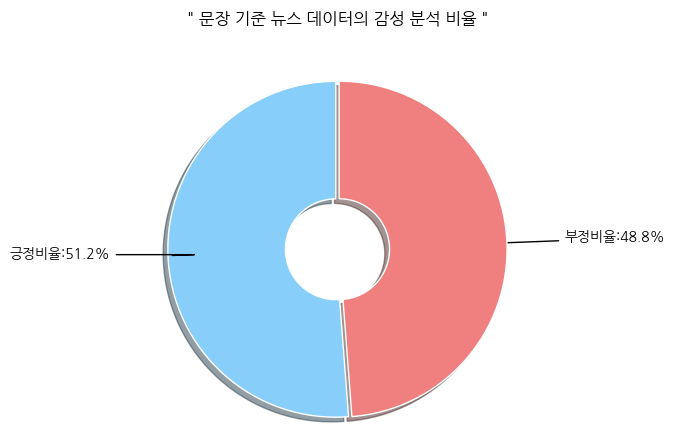

In [337]:
### Description 기준 감성 점수의 비율 ###

# 감성 점수가 0 이상의 경우 긍정
pos = len(all_data[all_data['Description_Sentiment_Score'] >= 0])/len(all_data)

# 감성 점수가 0 이하의 경우 부정
neg = len(all_data[all_data['Description_Sentiment_Score'] < -0])/len(all_data)

wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 1}
explode = [0.01, 0.01]

# 긍정부정중립 비율 그래프
colors = [ 'lightskyblue','lightcoral']
labels = ['긍정', '부정']
sizes = [pos, neg]

fig, ax = plt.subplots()
wedges, texts = ax.pie(sizes, colors=colors, startangle=90, explode=explode, shadow=True, wedgeprops=wedgeprops)

ax.axis('equal')

# 각 부분을 가리키는 화살표와 비율 레이블 추가
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    xytext = (1.35*np.sign(x), 1.4*y)
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    labeling = str(labels[i])+"비율:"
    ax.annotate(labeling+'{:.1f}%'.format(sizes[i]*100),
                xy=(x, y), xytext=xytext,
                horizontalalignment=horizontalalignment,
                arrowprops=dict(arrowstyle="-", connectionstyle=connectionstyle))

plt.title('" 문장 기준 뉴스 데이터의 감성 분석 비율 "', weight='bold', pad=30)

plt.show()

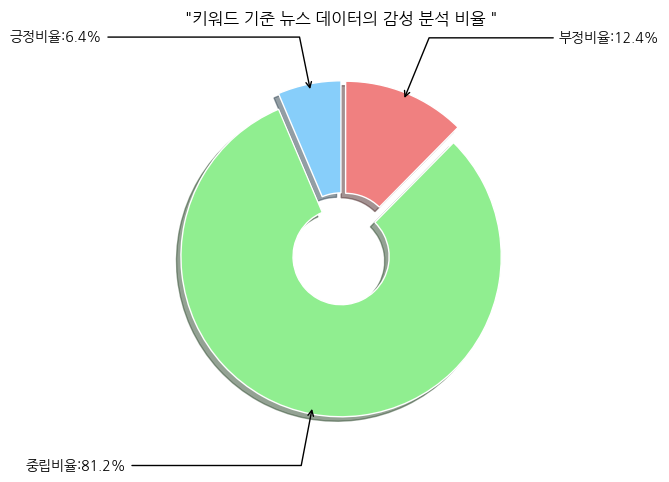

In [339]:
### Keywords 기준 감성 점수의 비율 ###

# 감성 점수가 0 이상의 경우 긍정
key_pos = len(all_data[all_data['Keywords_Sentiment_Score'] > 0])/len(all_data)
# 감성 점수가 0 인 경우 중립
key_nue = len(all_data[all_data['Keywords_Sentiment_Score'] == 0])/len(all_data)
# 감성 점수가 0 이하의 경우 부정
key_neg = len(all_data[all_data['Keywords_Sentiment_Score'] < 0])/len(all_data)

wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 1}
explode = [0.05, 0.05, 0.05]

# 긍정부정중립 비율 그래프
colors = [ 'lightskyblue','lightgreen','lightcoral']
labels = ['긍정', '중립', '부정']
sizes = [key_pos, key_nue, key_neg]

fig, ax = plt.subplots()
wedges, texts = ax.pie(sizes, colors=colors, startangle=90, explode=explode, shadow=True, wedgeprops=wedgeprops)

ax.axis('equal')

# 각 부분을 가리키는 화살표와 비율 레이블 추가
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    if labels[i] == '긍정':
        xytext = (-1.5, 1.3)
    else:
        xytext = (1.35*np.sign(x), 1.4*y)
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    labeling = str(labels[i])+"비율:"
    ax.annotate(labeling+'{:.1f}%'.format(sizes[i]*100),
                xy=(x, y), xytext=xytext,
                horizontalalignment=horizontalalignment,
                arrowprops=dict(arrowstyle="->", connectionstyle=connectionstyle))

plt.title('"키워드 기준 뉴스 데이터의 감성 분석 비율 "', weight='bold', pad=30)

plt.show()

#### 2. 새로운 감성 분석 사전 시도 : Finbert

#### Setting

In [183]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

import transformers
transformers.__version__

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

#### https://github.com/yya518/FinBERT 감성 모델 추출 : PPT 만들 때 해당 링크 설명 참조해서 첨부 바람

#### PPT 에는 생략해도 될거같은데, 해당 모델이 문장 길이의 제한이 있어서 일단 제목만 사용한다는 가정하에, TITLE로 감성 분석 실시

In [211]:
dataset = title_df['Title'].tolist()
title_df.head()

,Publisher,Date,Title,Description
0,The Guardian,2020.01.02,Tesla may have been on Autopilot in California...,Tesla may have been on Autopilot in California...
1,CarBuzz,2020.01.01,Tesla Cybertruck Makes Music Video Debut -,Tesla Cybertruck Makes Music Video Debut
2,CarBuzz,2020.01.01,All-New Tesla Model S Could Look Like This -,AllNew Tesla Model S Could Look Like This
3,Globes,2020.01.01,Tesla setting up Israel R&D office - -,Tesla setting up Israel RD office
4,Electrek,2020.01.01,Tesla updates 2020 Supercharger map with new l...,Tesla updates 2020 Supercharger map with new l...


In [212]:
nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer)
result = []
max_corpus = []

for index, corpus in enumerate(dataset):
    try:
        result.append(nlp(corpus))
    except:
        max_corpus.append(index)
print(max_corpus)

[]


In [340]:
title_df['result'] = result

title_df['label'] = title_df['result'].apply(lambda x: x[0]['label'])
title_df['score'] = title_df['result'].apply(lambda x: x[0]['score'])

title_df.drop(columns=['result'], inplace = True)
title_df

,Publisher,Date,Title,Description,label,score
0,The Guardian,2020.01.02,Tesla may have been on Autopilot in California...,Tesla may have been on Autopilot in California...,Neutral,0.938868
1,CarBuzz,2020.01.01,Tesla Cybertruck Makes Music Video Debut -,Tesla Cybertruck Makes Music Video Debut,Neutral,0.998336
2,CarBuzz,2020.01.01,All-New Tesla Model S Could Look Like This -,AllNew Tesla Model S Could Look Like This,Neutral,0.997566
3,Globes,2020.01.01,Tesla setting up Israel R&D office - -,Tesla setting up Israel RD office,Neutral,0.999999
4,Electrek,2020.01.01,Tesla updates 2020 Supercharger map with new l...,Tesla updates 2020 Supercharger map with new l...,Neutral,0.999961
...,...,...,...,...,...,...
17781,Torque News,2022.10.01,What A Tesla Model 3 Could Mean For You -,What A Tesla Model 3 Could Mean For You,Neutral,0.998351
17782,Hindustan Times,2022.10.02,Want to work for Tesla? Elon Musk tweets askin...,Want to work for Tesla Elon Musk tweets asking...,Neutral,0.999636
17783,CNN en Español,2022.10.01,El robot de Tesla caminó lentamente sobre el e...,El robot de Tesla camin lentamente sobre el es...,Neutral,0.999924
17784,TheStreet,2022.10.01,New Electric Vehicle Beats Tesla When it Comes...,New Electric Vehicle Beats Tesla When it Comes...,Neutral,0.966140


In [341]:
def cat_to_num(x):
    if x == 'Positive':
        return 3
    elif x == 'Neutral':
        return 2
    elif x == 'Negative':
        return 1

title_df['temp_score'] = title_df['label'].apply(cat_to_num)
title_df.head()

,Publisher,Date,Title,Description,label,score,temp_score
0,The Guardian,2020.01.02,Tesla may have been on Autopilot in California...,Tesla may have been on Autopilot in California...,Neutral,0.938868,2
1,CarBuzz,2020.01.01,Tesla Cybertruck Makes Music Video Debut -,Tesla Cybertruck Makes Music Video Debut,Neutral,0.998336,2
2,CarBuzz,2020.01.01,All-New Tesla Model S Could Look Like This -,AllNew Tesla Model S Could Look Like This,Neutral,0.997566,2
3,Globes,2020.01.01,Tesla setting up Israel R&D office - -,Tesla setting up Israel RD office,Neutral,0.999999,2
4,Electrek,2020.01.01,Tesla updates 2020 Supercharger map with new l...,Tesla updates 2020 Supercharger map with new l...,Neutral,0.999961,2


In [343]:
title_df = title_df.sort_values(by=["Date"], ascending=[True]) 
title_df['score'] = title_df['score']*title_df['temp_score']
title_df['Date'] = pd.to_datetime(title_df['Date'])
title_df.head()

,Publisher,Date,Title,Description,label,score,temp_score
1,CarBuzz,2020-01-01,Tesla Cybertruck Makes Music Video Debut -,Tesla Cybertruck Makes Music Video Debut,Neutral,1.996673,2
2,CarBuzz,2020-01-01,All-New Tesla Model S Could Look Like This -,AllNew Tesla Model S Could Look Like This,Neutral,1.995133,2
3,Globes,2020-01-01,Tesla setting up Israel R&D office - -,Tesla setting up Israel RD office,Neutral,1.999997,2
4,Electrek,2020-01-01,Tesla updates 2020 Supercharger map with new l...,Tesla updates 2020 Supercharger map with new l...,Neutral,1.999923,2
0,The Guardian,2020-01-02,Tesla may have been on Autopilot in California...,Tesla may have been on Autopilot in California...,Neutral,1.877735,2


In [344]:
title_df_grouped = title_df.groupby('Date')['score'].mean().reset_index()
title_df_grouped

,Date,score
0,2020-01-01,1.997931
1,2020-01-02,1.990072
2,2020-01-03,2.001309
3,2020-01-04,1.923445
4,2020-01-05,1.983029
...,...,...
1104,2023-08-09,1.999844
1105,2023-08-31,1.998305
1106,2023-11-16,1.995145
1107,2023-11-21,1.994482


In [345]:
score_df = title_df_grouped[title_df_grouped['Date'] <= '2022-12-31']
score_df

,Date,score
0,2020-01-01,1.997931
1,2020-01-02,1.990072
2,2020-01-03,2.001309
3,2020-01-04,1.923445
4,2020-01-05,1.983029
...,...,...
1091,2022-12-27,1.564022
1092,2022-12-28,1.854501
1093,2022-12-29,1.750728
1094,2022-12-30,1.920252


In [346]:
# 날짜에서 요일을 추출 (월요일: 0, 일요일: 6)
score_df['weekday'] = score_df['Date'].dt.weekday

# 요일이 토요일(5), 일요일(6)인 경우 그 다음 월요일로 변경한 날짜를 'group_date'라는 새로운 컬럼에 저장
score_df['group_date'] = score_df.apply(lambda row: row['Date'] + pd.DateOffset(days=(7 - row['weekday'])) if row['weekday'] in [5, 6] else row['Date'], axis=1)

# 'group_date' 컬럼의 이름을 'Date'로 변경
score_df.rename(columns={'group_date': 'new_date'}, inplace=True)
score_df.head()

C:\Users\jjska\AppData\Local\Temp\ipykernel_104056\3435620676.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df['weekday'] = score_df['Date'].dt.weekday
C:\Users\jjska\AppData\Local\Temp\ipykernel_104056\3435620676.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df['group_date'] = score_df.apply(lambda row: row['Date'] + pd.DateOffset(days=(7 - row['weekday'])) if row['weekday'] in [5, 6] else row['Date'], axis=1)
C:\Users\jjska\AppData\Local\Temp\ipykernel_104056\3435620676.py:8: Setti

,Date,score,weekday,new_date
0,2020-01-01,1.997931,2,2020-01-01
1,2020-01-02,1.990072,3,2020-01-02
2,2020-01-03,2.001309,4,2020-01-03
3,2020-01-04,1.923445,5,2020-01-06
4,2020-01-05,1.983029,6,2020-01-06


In [347]:
score_df = score_df.groupby('new_date')['score'].mean().reset_index()
score_df

,new_date,score
0,2020-01-01,1.997931
1,2020-01-02,1.990072
2,2020-01-03,2.001309
3,2020-01-06,1.955487
4,2020-01-07,1.933712
...,...,...
779,2022-12-27,1.564022
780,2022-12-28,1.854501
781,2022-12-29,1.750728
782,2022-12-30,1.920252


In [348]:
score_df = score_df.drop(score_df.index[-1])
score_df

,new_date,score
0,2020-01-01,1.997931
1,2020-01-02,1.990072
2,2020-01-03,2.001309
3,2020-01-06,1.955487
4,2020-01-07,1.933712
...,...,...
778,2022-12-26,1.779311
779,2022-12-27,1.564022
780,2022-12-28,1.854501
781,2022-12-29,1.750728


In [350]:
score_df.describe()

,score
count,783.000000
mean,1.951307
std,0.121009
min,1.525141
25%,1.869620
50%,1.956470
75%,2.028839
max,2.381133


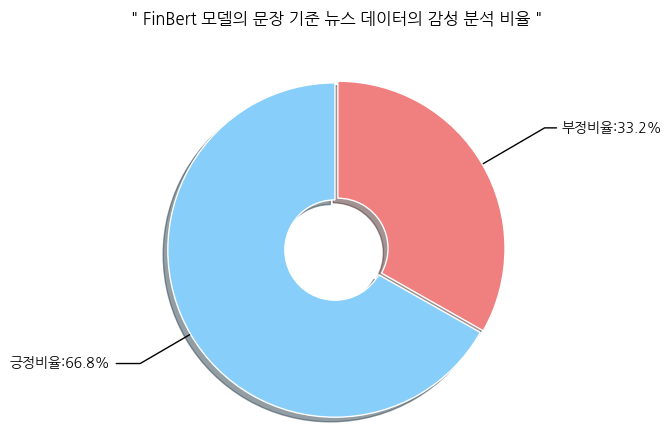

In [358]:
### Description 기준 감성 점수의 비율 ###

# 감성 점수가 0 이상의 경우 긍정
pos = len(score_df[score_df['score'] >= 1.9])/len(score_df)

# 감성 점수가 0 이하의 경우 부정
neg = len(score_df[score_df['score'] < 1.9])/len(score_df)

wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 1}
explode = [0.01, 0.01]

# 긍정부정중립 비율 그래프
colors = [ 'lightskyblue','lightcoral']
labels = ['긍정', '부정']
sizes = [pos, neg]

fig, ax = plt.subplots()
wedges, texts = ax.pie(sizes, colors=colors, startangle=90, explode=explode, shadow=True, wedgeprops=wedgeprops)

ax.axis('equal')

# 각 부분을 가리키는 화살표와 비율 레이블 추가
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    xytext = (1.35*np.sign(x), 1.4*y)
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    labeling = str(labels[i])+"비율:"
    ax.annotate(labeling+'{:.1f}%'.format(sizes[i]*100),
                xy=(x, y), xytext=xytext,
                horizontalalignment=horizontalalignment,
                arrowprops=dict(arrowstyle="-", connectionstyle=connectionstyle))

plt.title('" FinBert 모델의 문장 기준 뉴스 데이터의 감성 분석 비율 "', weight='bold', pad=30)

plt.show()

In [354]:
score_df

,new_date,score
0,2020-01-01,1.997931
1,2020-01-02,1.990072
2,2020-01-03,2.001309
3,2020-01-06,1.955487
4,2020-01-07,1.933712
...,...,...
778,2022-12-26,1.779311
779,2022-12-27,1.564022
780,2022-12-28,1.854501
781,2022-12-29,1.750728


In [388]:
all_data['finbert_score'] = score_df['score']
all_data

,Date,Publisher,Description,News_Count,corpus,Keywords,Description_Sentiment_Score,Keywords_Sentiment_Score,finbert_score
0,2020-01-01,"[Globes, Electrek, CarBuzz]",Tesla Cybertruck Makes Music Video Debut AllNe...,4,update make allnew office video set cybertruck...,"[allnew, map, israel, office, location, music,...",0.3794,0.0000,1.997931
1,2020-01-02,"[Torque, 01net, EL, GSMArena.com, Gulf, Exteri...",Tesla may have been on Autopilot in California...,21,price influential china voor end deja vdeo sup...,"[duizenden, goldsboro, coalicin, complacent, a...",0.0576,0.0000,1.990072
2,2020-01-03,"[CleanTechnica, ONLINE, CarBuzz, Khmer, Yahoo,...",Tesla to provide movies online games in its ca...,27,price china well med reduction provide youtube...,"[drd, bootleg, aralarda, dulle, auburn, inde, ...",0.0282,-0.4826,2.001309
3,2020-01-06,"[Torque, CleanTechnica, CarBuzz, Samochody, EL...",I70 crash one of 3 raising questions about Tes...,45,price ratio drodze question trigger kolejna es...,"[brandstofmotor, allweather, cristales, bomben...",0.0560,0.0000,1.955487
4,2020-01-07,"[CleanTechnica, Motori, Indonesia, CarBuzz, ZE...",China could be the swing factor for Teslas sto...,27,china shanghai ford nontesla lauto een mobil p...,"[gigafactora, ciclista, bloccher, benzinemotor...",0.0614,0.0000,1.933712
...,...,...,...,...,...,...,...,...,...
778,2022-12-26,"[Financial, CleanTechnica, Torque, CarBuzz, Ex...",Elon Musks Twitter obsession isnt the core rea...,24,shanghai upgrade fin discount que autoplus obs...,"[crit, timing, afridi, dtruite, tunnels, happe...",-0.2944,0.0000,1.779311
779,2022-12-27,"[Telex, Torque, Reuters, CarScoops, Forbes, CN...",Why Tesla Stocks Dropped So Much in 2022 Tesla...,14,price shanghai surprise reduce exec challenge ...,"[tampa, crit, timing, afridi, dtruite, tunnels...",-0.0171,0.0000,1.564022
780,2022-12-28,"[Torque, CleanTechnica, TODAY, Yahoo, Times, I...",Bus und Bahn in Oberhavel Weniger Zulassungen ...,18,storm disadvantage ford raise way sandy contin...,"[crit, timing, afridi, dtruite, tunnels, happe...",-0.1780,0.0000,1.854501
781,2022-12-29,"[Financial, Torque, CarBuzz, PAHomePage.com, Y...",Musk tells Tesla workers not to be bothered by...,20,price bearish ceo people pile add mode tell fa...,"[crit, timing, afridi, dtruite, tunnels, happe...",-0.2585,0.0000,1.750728


#### 3번 째, ProusAI/finbert

In [364]:
#### 출처 : https://songseungwon.tistory.com/124

In [362]:
from transformers import pipeline
sentiment_pipe = pipeline(model = 'ProsusAI/finbert')

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

C:\Users\jjska\anaconda3\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jjska\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [363]:
result_ins = []
max_corpus = []

for index, corpus in enumerate(dataset):
    try:
        result_ins.append(sentiment_pipe(corpus))
    except:
        max_corpus.append(index)
print(max_corpus)

[]


In [365]:
result_ins

[[{'label': 'negative', 'score': 0.89303058385849}],
 [{'label': 'neutral', 'score': 0.6504145860671997}],
 [{'label': 'neutral', 'score': 0.9129825830459595}],
 [{'label': 'neutral', 'score': 0.8214617371559143}],
 [{'label': 'neutral', 'score': 0.8040649890899658}],
 [{'label': 'neutral', 'score': 0.928188681602478}],
 [{'label': 'neutral', 'score': 0.7313817739486694}],
 [{'label': 'neutral', 'score': 0.4957285225391388}],
 [{'label': 'neutral', 'score': 0.7718703746795654}],
 [{'label': 'negative', 'score': 0.6828173398971558}],
 [{'label': 'neutral', 'score': 0.8956781625747681}],
 [{'label': 'neutral', 'score': 0.9186985492706299}],
 [{'label': 'positive', 'score': 0.6746858358383179}],
 [{'label': 'neutral', 'score': 0.9427877068519592}],
 [{'label': 'neutral', 'score': 0.8428212404251099}],
 [{'label': 'neutral', 'score': 0.9003562927246094}],
 [{'label': 'neutral', 'score': 0.8896573781967163}],
 [{'label': 'neutral', 'score': 0.9219189882278442}],
 [{'label': 'neutral', 'scor

In [368]:
title2_df['result'] = result_ins

title2_df['label'] = title2_df['result'].apply(lambda x: x[0]['label'])
title2_df['score'] = title2_df['result'].apply(lambda x: x[0]['score'])

title2_df.drop(columns=['result'], inplace = True)
title2_df

,Publisher,Date,Title,Description,label,score
0,The Guardian,2020.01.02,Tesla may have been on Autopilot in California...,Tesla may have been on Autopilot in California...,negative,0.893031
1,CarBuzz,2020.01.01,Tesla Cybertruck Makes Music Video Debut -,Tesla Cybertruck Makes Music Video Debut,neutral,0.650415
2,CarBuzz,2020.01.01,All-New Tesla Model S Could Look Like This -,AllNew Tesla Model S Could Look Like This,neutral,0.912983
3,Globes,2020.01.01,Tesla setting up Israel R&D office - -,Tesla setting up Israel RD office,neutral,0.821462
4,Electrek,2020.01.01,Tesla updates 2020 Supercharger map with new l...,Tesla updates 2020 Supercharger map with new l...,neutral,0.804065
...,...,...,...,...,...,...
17781,Torque News,2022.10.01,What A Tesla Model 3 Could Mean For You -,What A Tesla Model 3 Could Mean For You,neutral,0.930993
17782,Hindustan Times,2022.10.02,Want to work for Tesla? Elon Musk tweets askin...,Want to work for Tesla Elon Musk tweets asking...,neutral,0.926003
17783,CNN en Español,2022.10.01,El robot de Tesla caminó lentamente sobre el e...,El robot de Tesla camin lentamente sobre el es...,neutral,0.854166
17784,TheStreet,2022.10.01,New Electric Vehicle Beats Tesla When it Comes...,New Electric Vehicle Beats Tesla When it Comes...,neutral,0.821259


In [369]:
def cat_to_num(x):
    if x == 'positive':
        return 3
    elif x == 'neutral':
        return 2
    elif x == 'negative':
        return 1

title2_df['temp_score'] = title2_df['label'].apply(cat_to_num)
title2_df.head()

,Publisher,Date,Title,Description,label,score,temp_score
0,The Guardian,2020.01.02,Tesla may have been on Autopilot in California...,Tesla may have been on Autopilot in California...,negative,0.893031,1
1,CarBuzz,2020.01.01,Tesla Cybertruck Makes Music Video Debut -,Tesla Cybertruck Makes Music Video Debut,neutral,0.650415,2
2,CarBuzz,2020.01.01,All-New Tesla Model S Could Look Like This -,AllNew Tesla Model S Could Look Like This,neutral,0.912983,2
3,Globes,2020.01.01,Tesla setting up Israel R&D office - -,Tesla setting up Israel RD office,neutral,0.821462,2
4,Electrek,2020.01.01,Tesla updates 2020 Supercharger map with new l...,Tesla updates 2020 Supercharger map with new l...,neutral,0.804065,2


In [370]:
title2_df = title2_df.sort_values(by=["Date"], ascending=[True]) 
title2_df['score'] = title2_df['score']*title2_df['temp_score']
title2_df['Date'] = pd.to_datetime(title2_df['Date'])
title2_df.head()

,Publisher,Date,Title,Description,label,score,temp_score
1,CarBuzz,2020-01-01,Tesla Cybertruck Makes Music Video Debut -,Tesla Cybertruck Makes Music Video Debut,neutral,1.300829,2
2,CarBuzz,2020-01-01,All-New Tesla Model S Could Look Like This -,AllNew Tesla Model S Could Look Like This,neutral,1.825965,2
3,Globes,2020-01-01,Tesla setting up Israel R&D office - -,Tesla setting up Israel RD office,neutral,1.642923,2
4,Electrek,2020-01-01,Tesla updates 2020 Supercharger map with new l...,Tesla updates 2020 Supercharger map with new l...,neutral,1.608130,2
0,The Guardian,2020-01-02,Tesla may have been on Autopilot in California...,Tesla may have been on Autopilot in California...,negative,0.893031,1


In [379]:
title2_df.describe()

,score,temp_score
count,17786.000000,17786.000000
mean,1.627532,1.999213
std,0.459076,0.526604
min,0.372747,1.000000
25%,1.430647,2.000000
50%,1.735606,2.000000
75%,1.838074,2.000000
max,2.874338,3.000000


In [371]:
title_df2_grouped = title2_df.groupby('Date')['score'].mean().reset_index()
title_df2_grouped

,Date,score
0,2020-01-01,1.594462
1,2020-01-02,1.499752
2,2020-01-03,1.723811
3,2020-01-04,1.453395
4,2020-01-05,1.471414
...,...,...
1104,2023-08-09,1.786535
1105,2023-08-31,1.881780
1106,2023-11-16,1.807444
1107,2023-11-21,1.839773


In [372]:
score_df2 = title_df2_grouped[title_df2_grouped['Date'] <= '2022-12-31']
score_df2

,Date,score
0,2020-01-01,1.594462
1,2020-01-02,1.499752
2,2020-01-03,1.723811
3,2020-01-04,1.453395
4,2020-01-05,1.471414
...,...,...
1091,2022-12-27,1.381923
1092,2022-12-28,1.568400
1093,2022-12-29,1.401219
1094,2022-12-30,1.686019


In [373]:
# 날짜에서 요일을 추출 (월요일: 0, 일요일: 6)
score_df2['weekday'] = score_df2['Date'].dt.weekday

# 요일이 토요일(5), 일요일(6)인 경우 그 다음 월요일로 변경한 날짜를 'group_date'라는 새로운 컬럼에 저장
score_df2['group_date'] = score_df2.apply(lambda row: row['Date'] + pd.DateOffset(days=(7 - row['weekday'])) if row['weekday'] in [5, 6] else row['Date'], axis=1)

# 'group_date' 컬럼의 이름을 'Date'로 변경
score_df2.rename(columns={'group_date': 'new_date'}, inplace=True)
score_df2.head()

C:\Users\jjska\AppData\Local\Temp\ipykernel_104056\1289398578.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df2['weekday'] = score_df2['Date'].dt.weekday
C:\Users\jjska\AppData\Local\Temp\ipykernel_104056\1289398578.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df2['group_date'] = score_df2.apply(lambda row: row['Date'] + pd.DateOffset(days=(7 - row['weekday'])) if row['weekday'] in [5, 6] else row['Date'], axis=1)
C:\Users\jjska\AppData\Local\Temp\ipykernel_104056\1289398578.py:8: S

,Date,score,weekday,new_date
0,2020-01-01,1.594462,2,2020-01-01
1,2020-01-02,1.499752,3,2020-01-02
2,2020-01-03,1.723811,4,2020-01-03
3,2020-01-04,1.453395,5,2020-01-06
4,2020-01-05,1.471414,6,2020-01-06


In [374]:
score_df2 = score_df2.groupby('new_date')['score'].mean().reset_index()
score_df2

,new_date,score
0,2020-01-01,1.594462
1,2020-01-02,1.499752
2,2020-01-03,1.723811
3,2020-01-06,1.561630
4,2020-01-07,1.619998
...,...,...
779,2022-12-27,1.381923
780,2022-12-28,1.568400
781,2022-12-29,1.401219
782,2022-12-30,1.686019


In [375]:
score_df2 = score_df2.drop(score_df2.index[-1])
score_df2

,new_date,score
0,2020-01-01,1.594462
1,2020-01-02,1.499752
2,2020-01-03,1.723811
3,2020-01-06,1.561630
4,2020-01-07,1.619998
...,...,...
778,2022-12-26,1.467572
779,2022-12-27,1.381923
780,2022-12-28,1.568400
781,2022-12-29,1.401219


In [376]:
score_df2.describe()

,score
count,783.000000
mean,1.629709
std,0.119384
min,1.166151
25%,1.555492
50%,1.632089
75%,1.705736
max,1.996085


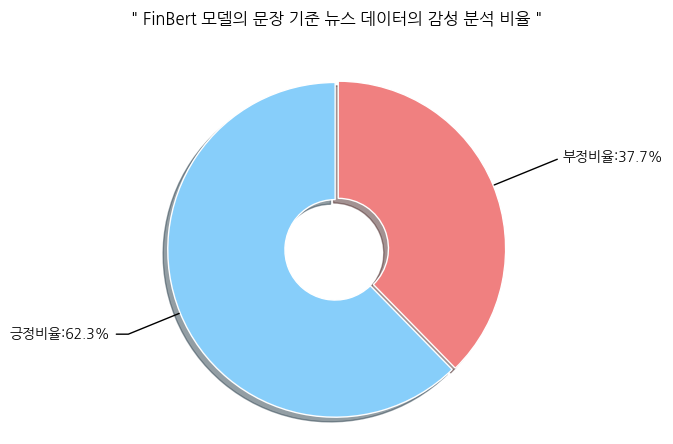

In [382]:
### Description 기준 감성 점수의 비율 ###

# 감성 점수가 0 이상의 경우 긍정
pos = len(score_df2[score_df2['score'] >= 1.6])/len(score_df2)

# 감성 점수가 0 이하의 경우 부정
neg = len(score_df2[score_df2['score'] < 1.6])/len(score_df2)

wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 1}
explode = [0.01, 0.01]

# 긍정부정중립 비율 그래프
colors = [ 'lightskyblue','lightcoral']
labels = ['긍정', '부정']
sizes = [pos, neg]

fig, ax = plt.subplots()
wedges, texts = ax.pie(sizes, colors=colors, startangle=90, explode=explode, shadow=True, wedgeprops=wedgeprops)

ax.axis('equal')

# 각 부분을 가리키는 화살표와 비율 레이블 추가
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    xytext = (1.35*np.sign(x), 1.4*y)
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    labeling = str(labels[i])+"비율:"
    ax.annotate(labeling+'{:.1f}%'.format(sizes[i]*100),
                xy=(x, y), xytext=xytext,
                horizontalalignment=horizontalalignment,
                arrowprops=dict(arrowstyle="-", connectionstyle=connectionstyle))

plt.title('" FinBert 모델의 문장 기준 뉴스 데이터의 감성 분석 비율 "', weight='bold', pad=30)

plt.show()

In [389]:
all_data['ProusAI/finbert_score'] = score_df2['score']
all_data

,Date,Publisher,Description,News_Count,corpus,Keywords,Description_Sentiment_Score,Keywords_Sentiment_Score,finbert_score,ProusAI/finbert_score
0,2020-01-01,"[Globes, Electrek, CarBuzz]",Tesla Cybertruck Makes Music Video Debut AllNe...,4,update make allnew office video set cybertruck...,"[allnew, map, israel, office, location, music,...",0.3794,0.0000,1.997931,1.594462
1,2020-01-02,"[Torque, 01net, EL, GSMArena.com, Gulf, Exteri...",Tesla may have been on Autopilot in California...,21,price influential china voor end deja vdeo sup...,"[duizenden, goldsboro, coalicin, complacent, a...",0.0576,0.0000,1.990072,1.499752
2,2020-01-03,"[CleanTechnica, ONLINE, CarBuzz, Khmer, Yahoo,...",Tesla to provide movies online games in its ca...,27,price china well med reduction provide youtube...,"[drd, bootleg, aralarda, dulle, auburn, inde, ...",0.0282,-0.4826,2.001309,1.723811
3,2020-01-06,"[Torque, CleanTechnica, CarBuzz, Samochody, EL...",I70 crash one of 3 raising questions about Tes...,45,price ratio drodze question trigger kolejna es...,"[brandstofmotor, allweather, cristales, bomben...",0.0560,0.0000,1.955487,1.561630
4,2020-01-07,"[CleanTechnica, Motori, Indonesia, CarBuzz, ZE...",China could be the swing factor for Teslas sto...,27,china shanghai ford nontesla lauto een mobil p...,"[gigafactora, ciclista, bloccher, benzinemotor...",0.0614,0.0000,1.933712,1.619998
...,...,...,...,...,...,...,...,...,...,...
778,2022-12-26,"[Financial, CleanTechnica, Torque, CarBuzz, Ex...",Elon Musks Twitter obsession isnt the core rea...,24,shanghai upgrade fin discount que autoplus obs...,"[crit, timing, afridi, dtruite, tunnels, happe...",-0.2944,0.0000,1.779311,1.467572
779,2022-12-27,"[Telex, Torque, Reuters, CarScoops, Forbes, CN...",Why Tesla Stocks Dropped So Much in 2022 Tesla...,14,price shanghai surprise reduce exec challenge ...,"[tampa, crit, timing, afridi, dtruite, tunnels...",-0.0171,0.0000,1.564022,1.381923
780,2022-12-28,"[Torque, CleanTechnica, TODAY, Yahoo, Times, I...",Bus und Bahn in Oberhavel Weniger Zulassungen ...,18,storm disadvantage ford raise way sandy contin...,"[crit, timing, afridi, dtruite, tunnels, happe...",-0.1780,0.0000,1.854501,1.568400
781,2022-12-29,"[Financial, Torque, CarBuzz, PAHomePage.com, Y...",Musk tells Tesla workers not to be bothered by...,20,price bearish ceo people pile add mode tell fa...,"[crit, timing, afridi, dtruite, tunnels, happe...",-0.2585,0.0000,1.750728,1.401219


In [390]:
all_data.columns

Index(['Date', 'Publisher', 'Description', 'News_Count', 'corpus', 'Keywords',
       'Description_Sentiment_Score', 'Keywords_Sentiment_Score',
       'finbert_score', 'ProusAI/finbert_score'],
      dtype='object')

In [391]:
columns  = ['Date', 'Publisher', 'Description', 'News_Count', 'corpus', 'Keywords', 'Description_Sentiment_Score',
            'Keywords_Sentiment_Score', 'finbert_score', 'ProusAI/finbert_score']

# 주어진 열만 포함하는 새 DataFrame 생성
filtered_data = all_data[columns]

# 'Date' 열을 인덱스로 설정
filtered_data.set_index('Date', inplace=True)
filtered_data.head()

filtered_data.to_csv('C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/Output/text_analysis_completed_data.csv')

In [392]:
filtered_data.head()

,Publisher,Description,News_Count,corpus,Keywords,Description_Sentiment_Score,Keywords_Sentiment_Score,finbert_score,ProusAI/finbert_score
Date,,,,,,,,,
2020-01-01,"[Globes, Electrek, CarBuzz]",Tesla Cybertruck Makes Music Video Debut AllNe...,4,update make allnew office video set cybertruck...,"[allnew, map, israel, office, location, music,...",0.3794,0.0000,1.997931,1.594462
2020-01-02,"[Torque, 01net, EL, GSMArena.com, Gulf, Exteri...",Tesla may have been on Autopilot in California...,21,price influential china voor end deja vdeo sup...,"[duizenden, goldsboro, coalicin, complacent, a...",0.0576,0.0000,1.990072,1.499752
2020-01-03,"[CleanTechnica, ONLINE, CarBuzz, Khmer, Yahoo,...",Tesla to provide movies online games in its ca...,27,price china well med reduction provide youtube...,"[drd, bootleg, aralarda, dulle, auburn, inde, ...",0.0282,-0.4826,2.001309,1.723811
2020-01-06,"[Torque, CleanTechnica, CarBuzz, Samochody, EL...",I70 crash one of 3 raising questions about Tes...,45,price ratio drodze question trigger kolejna es...,"[brandstofmotor, allweather, cristales, bomben...",0.0560,0.0000,1.955487,1.561630
2020-01-07,"[CleanTechnica, Motori, Indonesia, CarBuzz, ZE...",China could be the swing factor for Teslas sto...,27,china shanghai ford nontesla lauto een mobil p...,"[gigafactora, ciclista, bloccher, benzinemotor...",0.0614,0.0000,1.933712,1.619998
